In [5]:
import geopandas as gpd
import geopy
from shapely.geometry import Point
from geopy.geocoders import Nominatim

In [6]:
import pandas as pd
import numpy as np
import mpu
import seaborn as sns

In [7]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)

In [8]:
df = pd.read_excel('ATM_Bank_Misr_except_in_branches.xlsx')
df.head()

,ID,Address,منطقة,قسم / مركز,محافظة,Lat,Long,Nearest_Branch_distance,Nearest_Branch_Address,Lat_branch,Long_branch,منطقة الفرع,قسم / مركز الفرع,محافظة الفرع
0,1,Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.319696,30.835641,1480.524070,Fayoum Security Directorate building,29.310533,30.84672,قسم ثانى,قسم الفيوم,الفيوم
1,2,Fayoum AlHoriea St.,قسم اول,قسم الفيوم,الفيوم,29.308199,30.842229,382.882978,AlFayoum 45 AlHorreya St. Fayoum,29.307723,30.84614,قسم اول,قسم الفيوم,الفيوم
2,3,10th of Ramadan - Industrial Zone B1,قسم ثانى,قسم الفيوم,الفيوم,29.321487,30.837896,1488.462407,Fayoum Security Directorate building,29.310533,30.84672,قسم ثانى,قسم الفيوم,الفيوم
3,4,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,1593.570183,Fayoum Security Directorate building,29.310533,30.84672,قسم ثانى,قسم الفيوم,الفيوم
4,5,Fayoum train station,قسم اول,قسم الفيوم,الفيوم,29.308889,30.847499,184.899213,AlFayoum 45 AlHorreya St. Fayoum,29.307723,30.84614,قسم اول,قسم الفيوم,الفيوم


In [10]:
# we want to get the nearest k atms for every atm
# a 2nd copy of the data to compare with
temp_df = df

In [86]:
k = 2
def get_nearest_k_atms(x):
    # Lat and long of the atm in the current selected row
    lat1 = x[5]
    lon1 = x[6]
    # list of distances between the selected atm and all other atms
    distances_list = []
    
    # loop over all atms from the copied data (df)
    for i in range(len(df)):
        lat2 = df['Lat'].iloc[i]
        lon2 = df['Long'].iloc[i]
        # we don't want to compute the distance between the atm and itself
        if x[0] != df['ID'].iloc[i]:
            distances_list.append(mpu.haversine_distance((lat1, lon1), (lat2, lon2)))
        else:
            # when we ignore the atm with same id the size of the list decrease by 1 so
            # we put a dummy item in the list to fix the postioning in the data more info below
            distances_list.append(1000000000 + i)
    # we turn the list to np array to 1. use argsort (although it may be used on lists too), 
    # 2. get the value in the postions later
    
    distances_list = np.array(distances_list)
    distances_k_index = np.argsort(distances_list)[:k]
    
    # create k nearest atms with their infos 
    for i in range (k):
        # get the info of the atm
        for j in ['ID','Address','منطقة','قسم / مركز','محافظة','Lat','Long']:
            x[j+str(i+1)] = df[j].iloc[distances_k_index[i]]
        # get the min distances
        min_distance = distances_list[distances_k_index[i]] 
        # put the distances in columns
        x['distance'+str(i+1)] = min_distance
        x['distance'+str(i+1)+'_in_meter'] = min_distance * 1000

    return x

In [88]:
temp_df = temp_df[['ID','Address','منطقة','قسم / مركز','محافظة','Lat','Long']].apply(get_nearest_k_atms,axis=1)
temp_df.head(10)

,ID,Address,منطقة,قسم / مركز,محافظة,Lat,Long,ID1,Address1,منطقة1,قسم / مركز1,محافظة1,Lat1,Long1,distance1,distance1_in_meter,ID2,Address2,منطقة2,قسم / مركز2,محافظة2,Lat2,Long2,distance2,distance2_in_meter
0,1,Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.319696,30.835641,26,Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.319696,30.835641,0.000000,0.000000,3,10th of Ramadan - Industrial Zone B1,قسم ثانى,قسم الفيوم,الفيوم,29.321487,30.837896,0.295731,295.730570
1,2,Fayoum AlHoriea St.,قسم اول,قسم الفيوم,الفيوم,29.308199,30.842229,24,Fayoum AlHoriea St.,قسم اول,قسم الفيوم,الفيوم,29.308199,30.842229,0.000000,0.000000,29,Batal Alsalam St.- Fayoum,قسم اول,قسم الفيوم,الفيوم,29.304818,30.843850,0.407484,407.484119
2,3,10th of Ramadan - Industrial Zone B1,قسم ثانى,قسم الفيوم,الفيوم,29.321487,30.837896,4,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,0.107261,107.260588,25,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,0.107261,107.260588
3,4,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,25,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,0.000000,0.000000,3,10th of Ramadan - Industrial Zone B1,قسم ثانى,قسم الفيوم,الفيوم,29.321487,30.837896,0.107261,107.260588
4,5,Fayoum train station,قسم اول,قسم الفيوم,الفيوم,29.308889,30.847499,23,Fayoum train station,قسم اول,قسم الفيوم,الفيوم,29.308889,30.847499,0.000000,0.000000,11,"Jamal Abdel Nasser Street, behind the local po...",قسم اول,قسم الفيوم,الفيوم,29.309736,30.847641,0.095188,95.187942
5,6,Batal Alsalam St.- Fayoum,قسم اول,قسم الفيوم,الفيوم,29.304818,30.843850,29,Batal Alsalam St.- Fayoum,قسم اول,قسم الفيوم,الفيوم,29.304818,30.843850,0.000000,0.000000,2,Fayoum AlHoriea St.,قسم اول,قسم الفيوم,الفيوم,29.308199,30.842229,0.407484,407.484119
6,7,AlGomhoria St. Ibshaway,مدينه ابشواى,مركز أبشواى,الفيوم,29.370735,30.688374,30,AlGomhoria St. Ibshaway,مدينه ابشواى,مركز أبشواى,الفيوم,29.370735,30.688374,0.000000,0.000000,13,Vidimin Village - Senoures Center - Fayoum,فديمين,مركز سنورس,الفيوم,29.381256,30.777553,8.720038,8720.038109
7,8,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,27,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.000000,0.000000,28,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.000000,0.000000
8,9,23rd of July St. - Tamiya Center - Fayoum,مدينه طاميه,مركز طامية,الفيوم,29.474276,30.954961,19,Abdul Salam Aref Street - Senoras,مدينه سنورس,مركز سنورس,الفيوم,29.415401,30.864294,10.951595,10951.595475,10,Almadares St. Sanoras Sector Alfaioum,مدينه سنورس,مركز سنورس,الفيوم,29.408703,30.858720,11.832876,11832.876216
9,10,Almadares St. Sanoras Sector Alfaioum,مدينه سنورس,مركز سنورس,الفيوم,29.408703,30.858720,19,Abdul Salam Aref Street - Senoras,مدينه سنورس,مركز سنورس,الفيوم,29.415401,30.864294,0.919837,919.837114,14,Naqalifa Village - Senoras Sector - Fayoum,تقاليفة,مركز سنورس,الفيوم,29.396940,30.824684,3.547120,3547.119689


In [89]:
# let df be our new variable
df = temp_df

In [91]:
# there are 1779 atm that are near another atm or another 2 atms
df[df['distance1']==0]['ID'].count()

1779

In [94]:
df[(df['distance2_in_meter' ] <= 5)&(df['distance1_in_meter'] == 0)].sort_values(by=['distance1','distance2'],ascending=[False, False]).count()['ID']

77

In [96]:
df[(df['distance1_in_meter' ] == 0 )&(df['distance2_in_meter'] >= 5)&(df['distance2_in_meter'] <= 10)].sort_values(by=['distance2']).count()['ID']

48

In [97]:
df[(df['distance1_in_meter' ] == 0 )&(df['distance2_in_meter'] >= 10)&(df['distance2_in_meter'] <= 20)].sort_values(by=['distance2']).count()['ID']

44

In [99]:
df[(df['distance1_in_meter' ] == 0 )&(df['distance2_in_meter'] >= 20)&(df['distance2_in_meter'] <= 50)].sort_values(by=['distance2']).count()['ID']

52

In [100]:
df[(df['distance1_in_meter' ] == 0 )&(df['distance2_in_meter'] >= 0)&(df['distance2_in_meter'] <= 100)].sort_values(by=['distance2']).count()['ID']

321

In [101]:
df[df['distance2']==0]['ID'].count()
# there are 35 places that contains 3 atms in the same place

35

In [102]:
df[df['distance2']==0]

,ID,Address,منطقة,قسم / مركز,محافظة,Lat,Long,ID1,Address1,منطقة1,قسم / مركز1,محافظة1,Lat1,Long1,distance1,distance1_in_meter,ID2,Address2,منطقة2,قسم / مركز2,محافظة2,Lat2,Long2,distance2,distance2_in_meter
7,8,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,27,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.0,0.0,28,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.0,0.0
26,27,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,28,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.0,0.0,8,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.0,0.0
27,28,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,27,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.0,0.0,8,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.0,0.0
72,73,Ahmed Oraby St. - Alamiry Hospital - Kafr Alda...,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,116,Althawra St. Itay Albaroud,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,0.0,0.0,115,Ahmed Oraby St. - Alamiry Hospital - Kafr Alda...,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,0.0,0.0
114,115,Ahmed Oraby St. - Alamiry Hospital - Kafr Alda...,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,116,Althawra St. Itay Albaroud,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,0.0,0.0,73,Ahmed Oraby St. - Alamiry Hospital - Kafr Alda...,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,0.0,0.0
115,116,Althawra St. Itay Albaroud,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,115,Ahmed Oraby St. - Alamiry Hospital - Kafr Alda...,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,0.0,0.0,73,Ahmed Oraby St. - Alamiry Hospital - Kafr Alda...,كفر سليم,قسم كفرالدوار,البحيرة,31.139199,30.121385,0.0,0.0
1224,1225,Madinaty - New Cairo,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,1749,Madinaty,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,0.0,0.0,1894,Madinaty - New Cairo,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,0.0,0.0
1748,1749,Madinaty,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,1225,Madinaty - New Cairo,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,0.0,0.0,1894,Madinaty - New Cairo,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,0.0,0.0
1893,1894,Madinaty - New Cairo,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,1225,Madinaty - New Cairo,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,0.0,0.0,1749,Madinaty,الفردوس و الكوثر,قسم ثان القاهرة الجديدة,القاهرة,30.084686,31.639142,0.0,0.0
2935,2936,Port Said,بور فؤاد,قسم بور فؤاد,بورسعيد,31.247717,32.317760,2996,Port Fouad Sq. In Front of The Entrance to Por...,بور فؤاد,قسم بور فؤاد,بورسعيد,31.247717,32.317760,0.0,0.0,2983,Port Said,بور فؤاد,قسم بور فؤاد,بورسعيد,31.247717,32.317760,0.0,0.0


In [ ]:
# places that have 3 atms in the same place are new cites like madinty or elObour
# or hospitals

/home/abduallah/.local/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='distance2'>

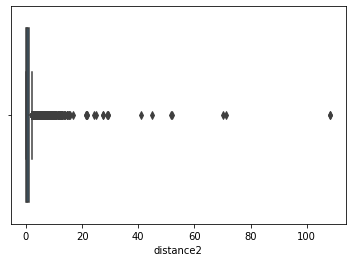

In [103]:
sns.boxplot(df['distance2'])

In [104]:
df.to_excel('ATMs_nearst_1st&2nd_except_in_branches.xlsx',index=0)

### ***Side-note***: model to measure whether the number of the atms satisfies some sort of equation(model) based on some features like: population number, where are the atms and any other useful features

In [105]:
ddt = pd.read_excel('ATMs_nearst_1st&2nd_except_in_branches.xlsx')
ddt.head(50)

,ID,Address,منطقة,قسم / مركز,محافظة,Lat,Long,ID1,Address1,منطقة1,قسم / مركز1,محافظة1,Lat1,Long1,distance1,distance1_in_meter,ID2,Address2,منطقة2,قسم / مركز2,محافظة2,Lat2,Long2,distance2,distance2_in_meter
0,1,Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.319696,30.835641,26,Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.319696,30.835641,0.000000,0.000000,3,10th of Ramadan - Industrial Zone B1,قسم ثانى,قسم الفيوم,الفيوم,29.321487,30.837896,0.295731,295.730570
1,2,Fayoum AlHoriea St.,قسم اول,قسم الفيوم,الفيوم,29.308199,30.842229,24,Fayoum AlHoriea St.,قسم اول,قسم الفيوم,الفيوم,29.308199,30.842229,0.000000,0.000000,29,Batal Alsalam St.- Fayoum,قسم اول,قسم الفيوم,الفيوم,29.304818,30.843850,0.407484,407.484119
2,3,10th of Ramadan - Industrial Zone B1,قسم ثانى,قسم الفيوم,الفيوم,29.321487,30.837896,4,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,0.107261,107.260588,25,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,0.107261,107.260588
3,4,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,25,Faculty of Arts Fayoum University,قسم ثانى,قسم الفيوم,الفيوم,29.322145,30.837087,0.000000,0.000000,3,10th of Ramadan - Industrial Zone B1,قسم ثانى,قسم الفيوم,الفيوم,29.321487,30.837896,0.107261,107.260588
4,5,Fayoum train station,قسم اول,قسم الفيوم,الفيوم,29.308889,30.847499,23,Fayoum train station,قسم اول,قسم الفيوم,الفيوم,29.308889,30.847499,0.000000,0.000000,11,"Jamal Abdel Nasser Street, behind the local po...",قسم اول,قسم الفيوم,الفيوم,29.309736,30.847641,0.095188,95.187942
5,6,Batal Alsalam St.- Fayoum,قسم اول,قسم الفيوم,الفيوم,29.304818,30.843850,29,Batal Alsalam St.- Fayoum,قسم اول,قسم الفيوم,الفيوم,29.304818,30.843850,0.000000,0.000000,2,Fayoum AlHoriea St.,قسم اول,قسم الفيوم,الفيوم,29.308199,30.842229,0.407484,407.484119
6,7,AlGomhoria St. Ibshaway,مدينه ابشواى,مركز أبشواى,الفيوم,29.370735,30.688374,30,AlGomhoria St. Ibshaway,مدينه ابشواى,مركز أبشواى,الفيوم,29.370735,30.688374,0.000000,0.000000,13,Vidimin Village - Senoures Center - Fayoum,فديمين,مركز سنورس,الفيوم,29.381256,30.777553,8.720038,8720.038109
7,8,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,27,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.000000,0.000000,28,Saad Zaghloul St.,قسم ثانى,قسم الفيوم,الفيوم,29.319011,30.851452,0.000000,0.000000
8,9,23rd of July St. - Tamiya Center - Fayoum,مدينه طاميه,مركز طامية,الفيوم,29.474276,30.954961,19,Abdul Salam Aref Street - Senoras,مدينه سنورس,مركز سنورس,الفيوم,29.415401,30.864294,10.951595,10951.595475,10,Almadares St. Sanoras Sector Alfaioum,مدينه سنورس,مركز سنورس,الفيوم,29.408703,30.858720,11.832876,11832.876216
9,10,Almadares St. Sanoras Sector Alfaioum,مدينه سنورس,مركز سنورس,الفيوم,29.408703,30.858720,19,Abdul Salam Aref Street - Senoras,مدينه سنورس,مركز سنورس,الفيوم,29.415401,30.864294,0.919837,919.837114,14,Naqalifa Village - Senoras Sector - Fayoum,تقاليفة,مركز سنورس,الفيوم,29.396940,30.824684,3.547120,3547.119689
